# Weather Classification

Welcome to this demonstration notebook for the Weather Classification Dataset and our trained models. This notebook provides an overview of the dataset, explores its structure, and showcases the performance of various models trained for weather classification.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from data_loading import WeatherDataModule, get_val_transforms, download_dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import seaborn as sns
import model as m

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Change the Values below to use different models

In [3]:
# names to be displayed in plots
model_names = ["EfficientnetB0", "EfficientnetB1", "MobileNetV2", "ResNet50", "Swin-T"]
# keys used for model loading in model.py
model_keys = ["efficientnetb0", "efficientnetb1", "mobilenet", "resnet50", "swin"]
# checkpoint paths for each model
ckpt_paths = ["models/efficientnetb0-val_acc=0.93.ckpt", "models/efficientnetb1-val_acc=0.92.ckpt", "models/mobilenet-val_acc=0.90.ckpt", "models/resnet50-val_acc=0.93.ckpt", "models/swin-val_acc=0.93.ckpt"]

Change the path below to use a different dataset

In [4]:
dataset_path = "data/weather-dataset"

## Dataset Overview

In [5]:
# download dataset if it doesn't exist
if(not os.path.exists(dataset_path)):
    download_dataset(dataset_path)
    print(f"Dataset downloaded to: {dataset_path}")

### Dataset Stats

In [6]:
# List dataset contents
classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")
print("Classes:", classes)

# Count total images
num_images = sum(len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes)
print(f"Total Number of Images: {num_images}")

Number of Classes: 11
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Total Number of Images: 6862


### Example Images

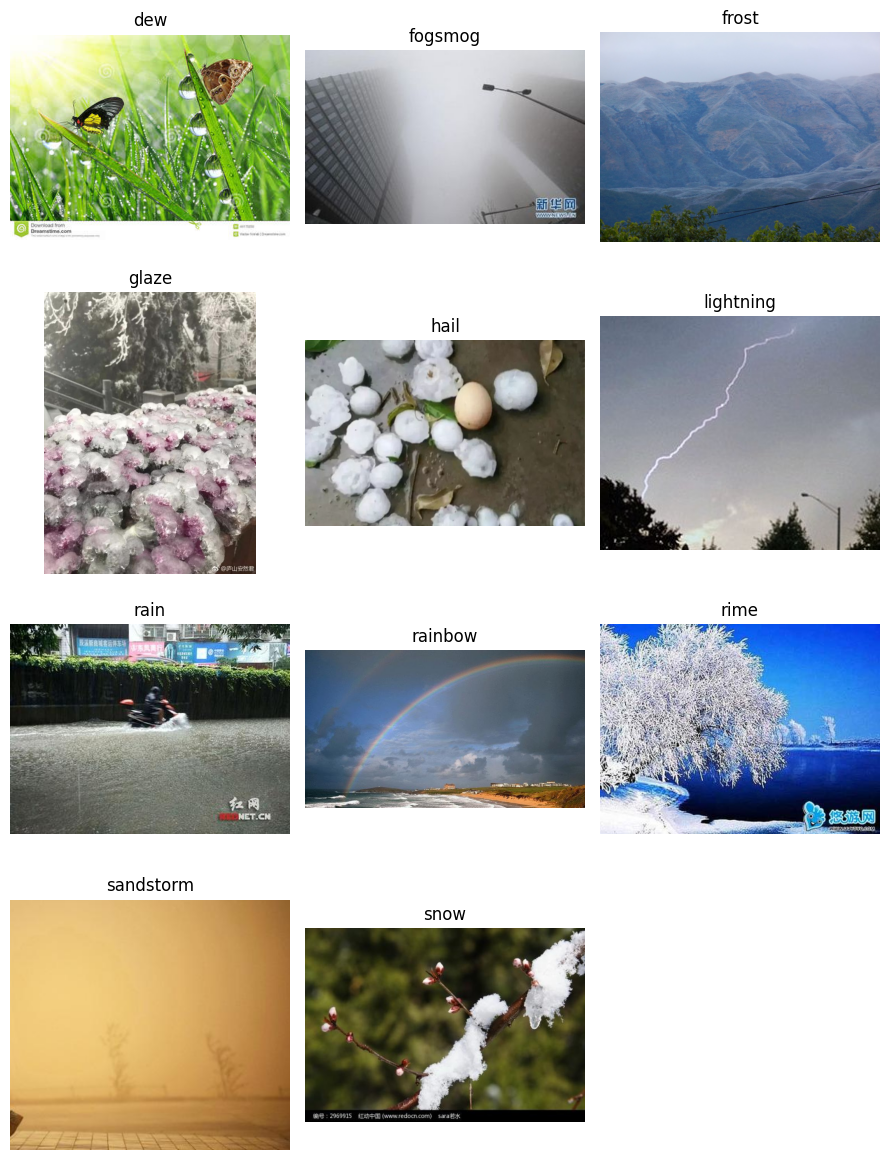

In [7]:
def show_samples(dataset_path, classes, images_per_row=3):
    num_classes = len(classes)
    rows = (num_classes + images_per_row - 1) // images_per_row
    
    fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 3, rows * 3))
    axes = np.array(axes).reshape(-1)

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        sample_image = np.random.choice(os.listdir(class_path), size=1)[0]
        
        img_path = os.path.join(class_path, sample_image)
        img = Image.open(img_path).convert("RGB")
        
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(cls, fontsize=12)
    
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

show_samples(dataset_path, classes, images_per_row=3)

### Class Distribution
As we can see in the following plot, the dataset has an uneven class distribution.\
During training, we have a hyperparameter allowing to handle this using class weights to balance the impact of each class.

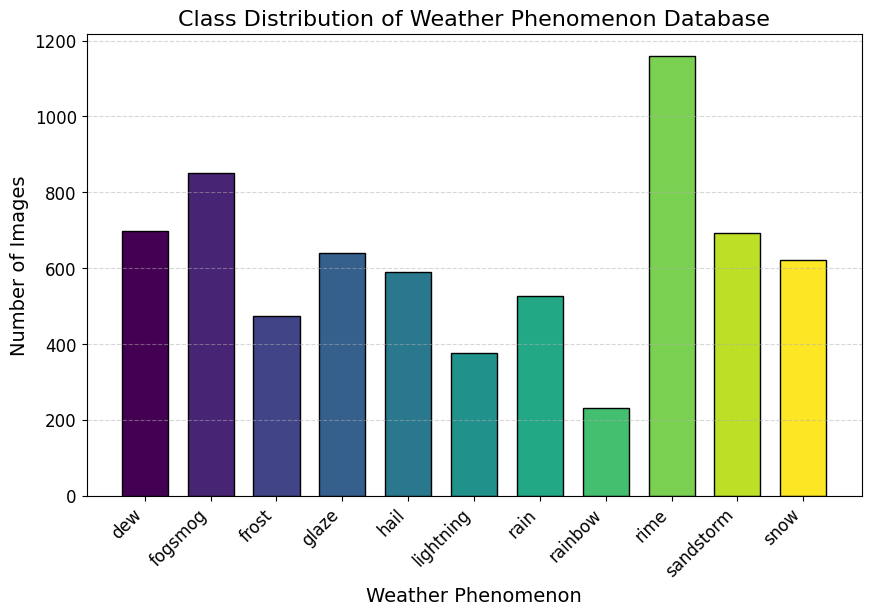

In [8]:
# Count images per class
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}
class_counts = dict(sorted(class_counts.items()))

colors = plt.cm.viridis(np.linspace(0, 1, len(class_counts)))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=plt.cm.viridis(np.linspace(0, 1, len(class_counts))), 
        edgecolor="black", width=0.7)

plt.xlabel("Weather Phenomenon", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.title("Class Distribution of Weather Phenomenon Database", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='dashed', alpha=0.5)

plt.show()

## Evaluating Model Performance

In [9]:
# load dataset and dataloader
datamodule = WeatherDataModule(dataset_path, 32, 1, get_val_transforms(), get_val_transforms())
datamodule.setup()
test_dataloader = datamodule.test_dataloader()
X_test = []
y_test = []
for images, labels in test_dataloader:
    X_test.append(images)
    y_test.append(labels)
X_test = torch.cat(X_test)
y_test = torch.cat(y_test)

In [10]:
# initialize models
models = []
for model_name, model_key, ckpt_path in zip(model_names, model_keys, ckpt_paths):
    model = m.get_base_model(model_key, 11)
    state_dict = torch.load(ckpt_path, weights_only=True, map_location=torch.device('cpu'))['state_dict']
    for key in list(state_dict.keys()):
        state_dict[key.replace("model.", "")] = state_dict.pop(key)
    model.load_state_dict(state_dict,strict=False)
    models.append(model)
    print(f"Model {model_name} loaded with checkpoint: {ckpt_path}")

Model EfficientnetB0 loaded with checkpoint: models/efficientnetb0-val_acc=0.93.ckpt
Model EfficientnetB1 loaded with checkpoint: models/efficientnetb1-val_acc=0.92.ckpt
Model MobileNetV2 loaded with checkpoint: models/mobilenet-val_acc=0.90.ckpt
Model ResNet50 loaded with checkpoint: models/resnet50-val_acc=0.93.ckpt


/home/joscha/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Model Swin-T loaded with checkpoint: models/swin-val_acc=0.93.ckpt


In [11]:
# Predictions
model_predictions = {}
X_test
for model_name, model in zip(model_names, models):
    print(f"Predicting using {model_name}...")
    model.to(device)
    model.eval()
    with torch.no_grad():
        model_predictions[model_name] = []
        for batch in X_test.split(32):
            y_pred = model(batch.to(device))
            y_pred = y_pred.to("cpu")
            y_pred = torch.argmax(y_pred, dim=1)
            y_pred = y_pred.numpy()
            model_predictions[model_name].append(y_pred)
        model_predictions[model_name] = np.concatenate(model_predictions[model_name])
    torch.cuda.empty_cache()


Predicting using EfficientnetB0...
Predicting using EfficientnetB1...
Predicting using MobileNetV2...
Predicting using ResNet50...
Predicting using Swin-T...


### Accuracy and F1 Score

In [12]:
# evaluate models
model_scores = {}
y_true = y_test

for model_name, y_pred in model_predictions.items():
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    model_scores[model_name] = {"Accuracy": accuracy, "F1-Score": f1}


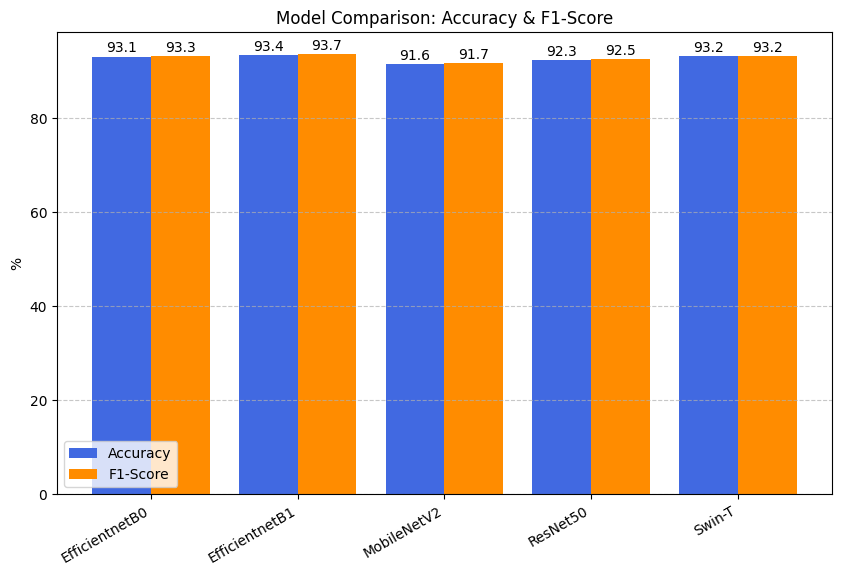

In [21]:
# plot model evaluation
accuracies = [model_scores[m]["Accuracy"] * 100 for m in model_names]
f1_scores = [model_scores[m]["F1-Score"] * 100 for m in model_names]
x = np.arange(len(model_names))

plt.figure(figsize=(10, 6))
bar_width = 0.4
bars1 = plt.bar(x - bar_width / 2, accuracies, width=bar_width, label="Accuracy", color="royalblue")
bars2 = plt.bar(x + bar_width / 2, f1_scores, width=bar_width, label="F1-Score", color="darkorange")
plt.bar_label(bars1, fmt='%.1f', padding=1)
plt.bar_label(bars2, fmt='%.1f', padding=1)

plt.xticks(x, model_names, rotation=30, ha="right")
plt.ylabel("%")
plt.title("Model Comparison: Accuracy & F1-Score")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Confusion Matrices


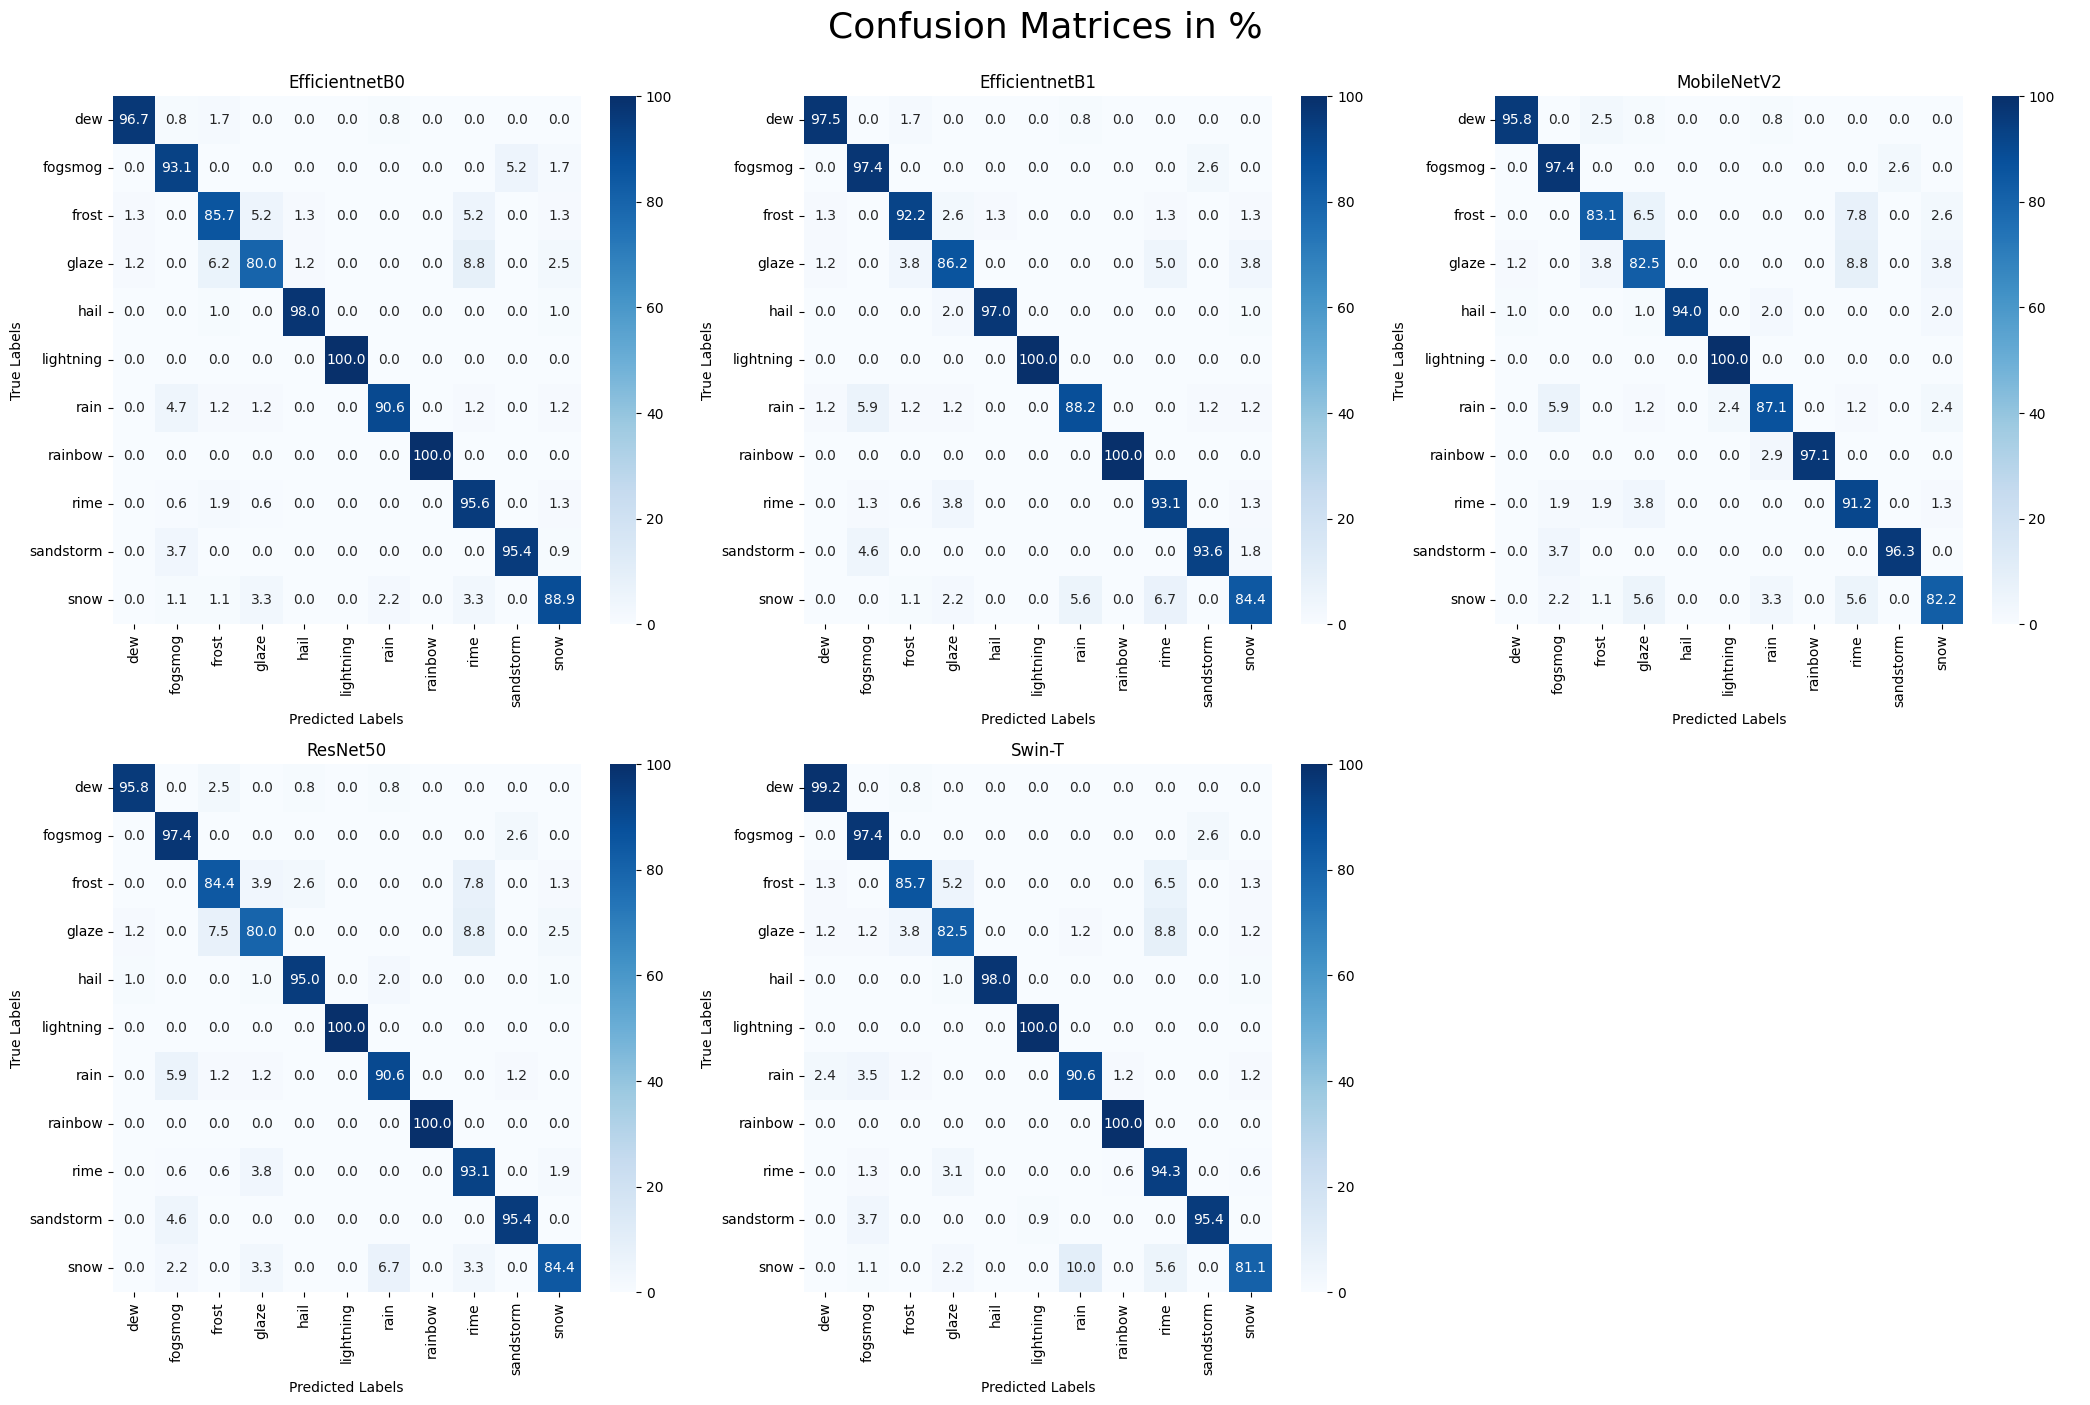

In [14]:
# plot confusion matrices
num_models = len(models)
num_cols = 3
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 7, num_rows * 7))
fig.suptitle("Confusion Matrices in %", fontsize=26, y=1)

axes = axes.flatten()

for ax, (model_name, y_pred) in zip(axes, model_predictions.items()):
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize to percentages
    
    sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

for ax in axes[len(model_predictions):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Samples of Missclassified Images

In [15]:
# load dataset and dataloader without transforms
dataset = WeatherDataModule(dataset_path, 32, 1, None, None)
dataset.setup()
test_dataloader = dataset.test_dataloader()

EfficientnetB0:


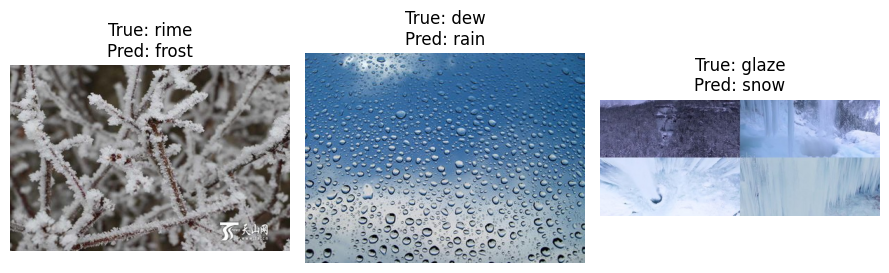

EfficientnetB1:


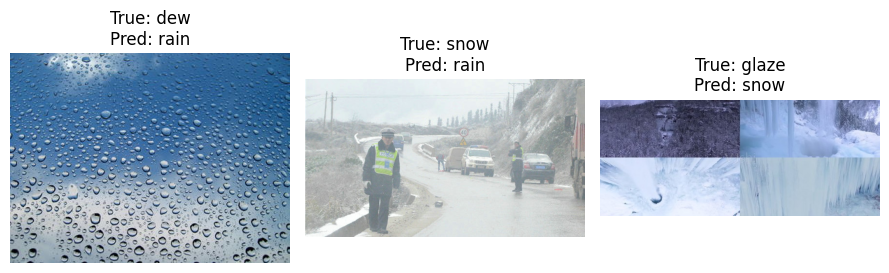

MobileNetV2:


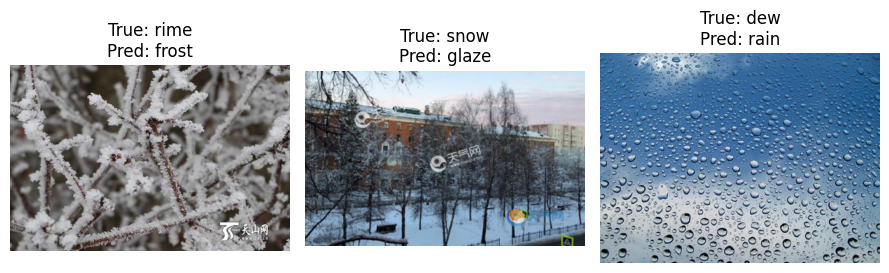

ResNet50:


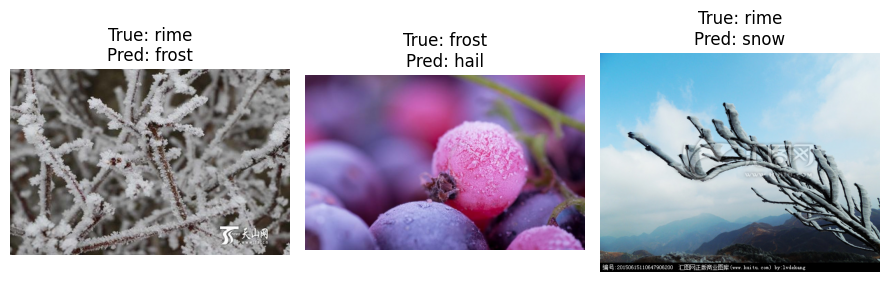

Swin-T:


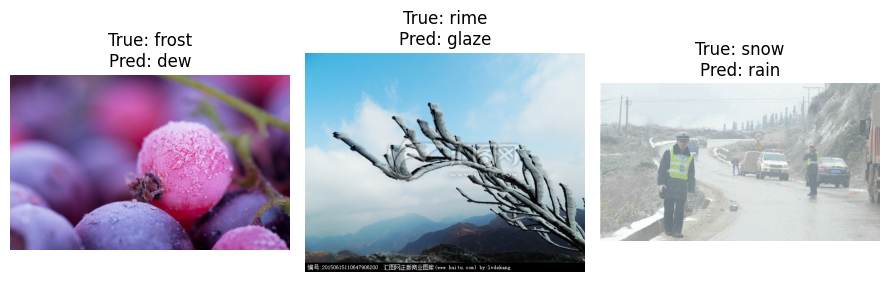

In [16]:
# show examples of missclassified images
def show_misclassified_samples(dataloader, y_true, y_pred, num_samples=3):
    misclassified_indices = np.where(y_true != y_pred)[0]
    num_samples = min(num_samples, len(misclassified_indices))
    
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))
    
    for i, idx in enumerate(misclassified_indices[:num_samples]):
        img = dataloader.dataset[idx][0]
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}", fontsize=12)
    
    plt.tight_layout()
    plt.show()

y_true_np = y_true.numpy()
for model_name, y_pred in model_predictions.items():
    print(f"{model_name}:")
    show_misclassified_samples(test_dataloader, y_true_np, y_pred, num_samples=3)


The following images are examples where none of the models were able to correctly classify the weather condition.

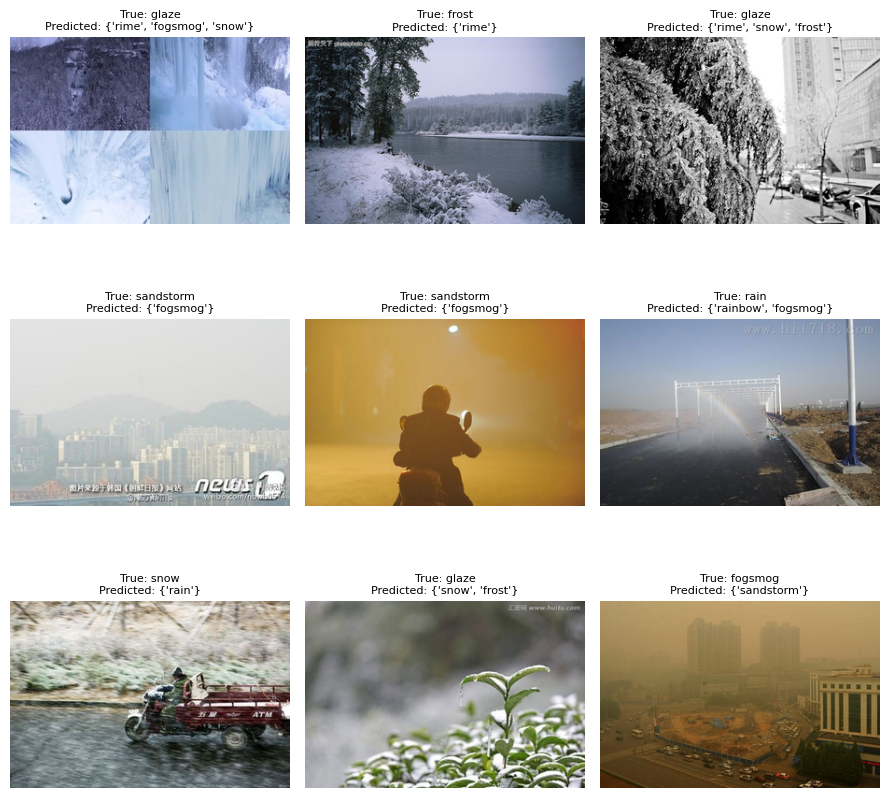

In [17]:
# show examples of missclassified images
def show_common_misclassified_samples(dataloader, y_true, y_preds, num_samples=3):
    misclassified_indices = np.where(np.all([y_true != y_pred for y_pred in y_preds], axis=0))[0]
    
    num_samples = min(num_samples, len(misclassified_indices))
    num_cols = 3
    num_rows = (num_samples + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))
    axes = axes.flatten()
    
    for i, idx in enumerate(misclassified_indices[:num_samples]):
        img = dataloader.dataset[idx][0]
        img = img.resize((300,200), Image.LANCZOS)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {classes[y_true[idx]]}\nPredicted: {set([classes[y_pred[idx]] for y_pred in y_preds])}", fontsize=8)
    
    for j in range(num_samples, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

y_preds = list(model_predictions.values())
show_common_misclassified_samples(test_dataloader, y_true_np, y_preds, num_samples=9)